“We have adhered to all tenants of the Duke Community Standard in the completion of this assignment.”- Marc Chmielewski, Andrew Sander, Yi Chen

# Introduction

In the game Pokemon, there are discrete categories of Pokemon combatants. These categories are called types and generally represented by the physical attributes of the pokemon. Said attributes often include color, body features, and accessories. A player can have an advantage or disadvantage in the game depending on what type of Pokemon they have in battle. A Pokemon whose type is super-effective against an opposing Pokemon is more likely to win a game than the other Pokemon that is weak to that type. It is important, then, for a player to be able to classify which type of Pokemon they have and that they are facing as soon as possible. A convolutional neural network (CNN) that could determine a Pokemon’s type based on the image of the creature as input would be a huge asset to the player, especially in a competitive tournament environment. 

The main question that we are asking is what attributes of a Pokemon’s appearance contribute to its type label, and how much each of those attributes matter in determining the type. We hypothesize that the color palettes of the images will contribute most to classification, followed closely by combinations of geometrical shapes such as flames and plants. The presence or absence of curvatures or sharp points can also play a role in classification. To those who are unfamiliar with Pokemon, this project would be interesting in its ability to detect both subtle and hidden patterns in artwork and categorize that artwork based on those patterns. This process could be used by art students, for example, to sift through a large database of images and find objects that have certain attributes that are interesting to them.

## Prior Research
A generative adversarial network (GAN) was created a couple of years ago that generated new Pokemon based on a database of preexisting Pokemon. (The data can be found here and the Git repository here). Though this attempt was unsuccessful, largely due to the small amount of training data that the developer used, a network that is simply classifying Pokemon testing data as opposed to generating new data will likely be much more feasible. 

Previous type classifiers have been made using characteristics of the Pokemon other than physical appearance. A model with a similar goal is linked here. This model attempts to predict the type of a Pokemon based on numerical gameplay attributes; primarily battle statistics and physical attributes (attack, defense, speed, weight etc). Our model is unique in that it will be determining the type solely with regards to the target Pokemon's physical appearance. In other words, this model’s classification procedure will be driven exclusively by image composition and coloration. 


# Dataset
A dataset of 813 images of Pokemon was acquired from the previously mentioned GAN project. All of the sourced images are 256x256 pixels, of type .jpg, and have white backgrounds. Additionally, some Pokemon are represented in different positions/different art styles as a result of an in-game mechanic called Mega Evolution. Because these data points are compositional outliers, that is, they vary substantially from the otherwise relatively consistent standards of image color and structure, the team initially considered discarding these data points. However, given the relative sparsity of the data, we elected that they should be kept in. Given that the team is utilizing a supervised approach to the classification question, the data were subsequently labeled according to their types. There are 18 total types of Pokemon, and a histogram of the distribution of types is depicted below.

[Somehow insert an image into this notebook]

In [30]:
# Importing Necessary Packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL
import pandas as pd
from PIL import Image
from tqdm import tqdm
os.environ['KMP_DUPLICATE_LIB_OK']='True'
PATH = os.getcwd()

# ----------------------------Packages below are Keras-specific-------------------------------------------
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential


# Data Preprocessing

Due to the sparsity of the base dataset, it became immediately apparent that the team would need to augment it with additional images of Pokemon. However, there has been a large amount of variation in how Pokemon have been depicted in the media over time. For example, between Generations V and VI, the main-series games made the jump from 2D to 3D for the first time, and with this transition came a total rework of the library of Pokemon sprites. While we as humans can still easily tell that the two Pokemon in the figures below are both Squirtles, it’s logical to assume that an ML algorithm may have a harder time doing so. Thus, the team opted to restrict themselves to the traditional 2D depictions of Pokemon often seen in the anime and other promotional materials. 

## Train, Test, and Validation Set Division
Before implementing a machine learning model, it was also necessary to sort the dataset into training, validation, and testing datasets. The training set contained 70% of the total data, validation contained 10%, and testing 20%. It was important to make sure the data was stratified, that is the same ratio amongst types should appear across all three data sets. This ensured that the training model would not overfit to a specific type of Pokemon and test with types it had never seen before. A script was written to take the entire data set (both base and augmented images) and sort them into various training, validation, and testing sets; the type distributions are constant across the three sets. 

## Image Array Preparation
The images needed to be converted into numpy matrices in order to be processed by the neural network. We read the images in as a matrix of pixel values and normalized them between 0 and 1. Then, we resized the images so that they are 50x50 pixels. Therefore, the 3D matrix for each image, including color channels, is 50x50x3. Finally, we created a 4D matrix with the dimensions (number of images)x50x50x3, and we repeated for training, testing, and validation datasets. 

## Label Array Preparation
We created a dictionary where keys are filenames and values are integer representations of the 18 Pokemon types. Therefore, every time an image is processed its label is added to the vector. This was also repeated for training, testing, and validation datasets. 

All numpy arrays created are then saved to our disk as .npy files. They are loaded below: 

In [19]:
x_train = np.load("xtrain.npy")
y_train = np.load("ytrain.npy")
x_test = np.load("xtest.npy")
y_test = np.load("ytest.npy")
x_valid = np.load("xvalidation.npy")
y_valid = np.load("yvalidation.npy")
print("Training set: {} images, testing set: {} images, validation set: {} images".
      format(len(y_train), len(y_test), len(y_valid)))

Training set: 5784 images, testing set: 1633 images, validation set: 815 images


In [13]:
x_train.shape

(5784, 50, 50, 3)

Below is a visualization of one of the train images: 

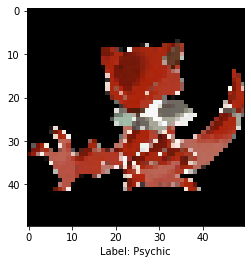

In [17]:
plt.grid(False)
plt.imshow(x_train[0])
plt.xlabel("Label: Psychic")
plt.show()

The code below converts our labels to categorical form, which Keras uses to train models. 

In [20]:
y_train = keras.utils.to_categorical(y_train, num_classes = 18)
y_test = keras.utils.to_categorical(y_test, num_classes = 18)
y_valid = keras.utils.to_categorical(y_valid, num_classes = 18)

# Setting Up the CNN
Due to the fact that this is a classification task and the data is image-based, the team opted to utilize a convolutional neural network (CNN) to develop the ML model. A CNN is optimal for this task as the data has many more features than a simple multi-layer perceptron could reasonably ascertain. Furthermore, unlike the individual Multi-layer Perceptrons (MLPs), CNN’s are capable of parsing images with RGB-color channel information as n1 x n2  x 3-dimensional vectors. Given that the primary features that the model used to classify the images were based on color and composition, the fact that CNN’s can handle color is invaluable. 

The model training was performed using the Keras package from TensorFlow. The hypermarameters below are determined to yield the best results after a few training attempts. 

In [21]:
num_classes = 18
epochs = 150
num_predictions = 20
batch_size = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'pokemonModel.h5'

# Neural Network Architecture

In [22]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same',
                        input_shape=(50, 50, 3), 
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(32, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.25),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
                        
])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])



# Training the Model

In [ ]:
history = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

The model that we trained was saved to the working directory, and is loaded below: 

In [24]:
savedModel = load_model(os.path.join(os.getcwd(), 'saved_models/pokemonModel.h5'))

# Results


In [31]:
scores = savedModel.evaluate(x_valid, y_valid, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.95582825


After training for 150 epochs, the model performed very well on the testing and validation sets.
The model achieved 96% accuracy with images in the validation set. The accuracy of the model on the training and testing sets (shown as the validation data in the figures below). While the model had success on the testing and validation sets, the model falls short on classifying Pokemon of differing orientation from that in the training set. For example, see the two examples of Lugia below. The image to the left is the image that the model used to train, and the image to the right is one not included in the dataset. The second image was classified incorrectly, showing that model does not do well with classifying images of differing orientation.




# Conclusion

Overall, the model was generally successful at classifying Pokemon, and was even successful in classifying several novel Pokemon from the release of Pokemon Sword and Shield in November of 2019. A notable deficit was observed in the classification of dragon type Pokemon, which can be largely attributed to their diverse coloration and overall form factor. Additionally, the model often struggled with Pokemon that were in some way non-linearly transformed from their training images. This was often caused by the Pokemon adopting a different pose or posture but could also be attributed to alternative forms of depiction. Finally, some multi-type Pokemon, such as Scrafty, were erroneously categorized into their “secondary” type, which while not inaccurate, was not the intended behavior of the model. 

Future iterations of the model will likely include additional training layers to permit for the uptake of additional latent features within the data, utilize Keras’ in-built real-time data augmentation features to dynamically improve the dataset, and utilize more training echelons to increase the overall resolution of the hidden-layer filters. All three of these changes should improve the model’s capability to classify these oft-misclassified Pokemon.

